<a href="https://colab.research.google.com/github/aponamarev/NormalizationLayarsComparison/blob/master/layers_weightnormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.



In [0]:
#@title Licensed under the Apache License, Version 2.0
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons Layers: WeightNormalization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/addons/tutorials/layers_weightnormalization"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/layers_weightnormalization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/addons/blob/master/docs/tutorials/layers_weightnormalization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/addons/docs/tutorials/layers_weightnormalization.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook will demonstrate how to use the Weight Normalization layer and how it can improve convergence.


# WeightNormalization

A Simple Reparameterization to Accelerate Training of Deep Neural Networks:

Tim Salimans, Diederik P. Kingma (2016)

> By reparameterizing the weights in this way we improve the conditioning of the optimization problem and we speed up convergence of stochastic gradient descent. Our reparameterization is inspired by batch normalization but does not introduce any dependencies between the examples in a minibatch. This means that our method can also be applied successfully to recurrent models such as LSTMs and to noise-sensitive applications such as deep reinforcement learning or generative models, for which batch normalization is less well suited. Although our method is much simpler, it still provides much of the speed-up of full batch normalization. In addition, the computational overhead of our method is lower, permitting more optimization steps to be taken in the same amount of time.

> https://arxiv.org/abs/1602.07868 

<img src="https://raw.githubusercontent.com/seanpmorgan/tf-weightnorm/master/static/wrapped-graph.png" width="80%"><br><br>


## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [4]:
!pip install  --no-deps tensorflow-addons~=0.6

In [0]:
import tensorflow_addons as tfa
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# Hyper Parameters
batch_size = 512
epochs = 5
num_classes=10

## Build Models

In [0]:
# Standard ConvNet
reg_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [0]:
# Layer Norm ConvNet
ln_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, 5, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 5, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [0]:
# WeightNorm ConvNet
wn_model = tf.keras.Sequential([
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(6, 5, activation='relu')),
    tf.keras.layers.MaxPooling2D(2, 2),
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(16, 5, activation='relu')),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(120, activation='relu')),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(84, activation='relu')),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_classes, activation='softmax')),
])

In [0]:
# Batch Norm ConvNet
bn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, 5, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, 5, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [0]:
# WeightNorm ConvNet
wln_model = tf.keras.Sequential([
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(6, 5, activation='relu')),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(16, 5, activation='relu')),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(120, activation='relu')),
    tf.keras.layers.LayerNormalization(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(84, activation='relu')),
    tf.keras.layers.LayerNormalization(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_classes, activation='softmax')),
])

## Load Data

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

## Train Models

In [13]:
reg_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

reg_history = reg_model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 4s 70us/sample - loss: 1.9234 - accuracy: 0.3008 - val_loss: 1.7122 - val_accuracy: 0.3809
Epoch 2/5
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5980 - accuracy: 0.4251 - val_loss: 1.5893 - val_accuracy: 0.4202
Epoch 3/5
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4815 - accuracy: 0.4653 - val_loss: 1.4799 - val_accuracy: 0.4666
Epoch 4/5
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4223 - accuracy: 0.4890 - val_loss: 1.4202 - val_accuracy: 0.4876
Epoch 5/5
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3763 - accuracy: 0.5073 - val_loss: 1.3641 - val_accuracy: 0.5132


In [14]:
ln_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

ln_history = ln_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 5s 93us/sample - loss: 2.0043 - accuracy: 0.2643 - val_loss: 1.6997 - val_accuracy: 0.3854
Epoch 2/5
50000/50000 [==============================] - 4s 78us/sample - loss: 1.5830 - accuracy: 0.4260 - val_loss: 1.5151 - val_accuracy: 0.4548
Epoch 3/5
50000/50000 [==============================] - 4s 79us/sample - loss: 1.4297 - accuracy: 0.4872 - val_loss: 1.3956 - val_accuracy: 0.5023
Epoch 4/5
50000/50000 [==============================] - 4s 79us/sample - loss: 1.3500 - accuracy: 0.5181 - val_loss: 1.3463 - val_accuracy: 0.5167
Epoch 5/5
50000/50000 [==============================] - 4s 79us/sample - loss: 1.2907 - accuracy: 0.5410 - val_loss: 1.2882 - val_accuracy: 0.5391


In [15]:
wn_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

wn_history = wn_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_data=(x_test, y_test),
                          shuffle=True)

Instructions for updating:
Please use `layer.add_weight` method instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 3s 56us/sample - loss: 1.7757 - accuracy: 0.3517 - val_loss: 1.6071 - val_accuracy: 0.4214
Epoch 2/5
50000/50000 [==============================] - 1s 22us/sample - loss: 1.4830 - accuracy: 0.4651 - val_loss: 1.4281 - val_accuracy: 0.4890
Epoch 3/5
50000/50000 [==============================] - 1s 21us/sample - loss: 1.3647 - accuracy: 0.5110 - val_loss: 1.3640 - val_accuracy: 0.5117
Epoch 4/5
50000/50000 [==============================] - 1s 21us/sample - loss: 1.2817 - accuracy: 0.5424 - val_loss: 1.3237 - val_accuracy: 0.5241
Epoch 5/5
50000/50000 [==============================] - 1s 21us/sample - loss: 1.2149 - accuracy: 0.5651 - val_loss: 1.2642 - val_accuracy: 0.5457


In [0]:
epochs_long = 25

In [17]:
bn_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

bn_history = bn_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs_long,
                          validation_data=(x_test, y_test),
                          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 36us/sample - loss: 1.8179 - accuracy: 0.3583 - val_loss: 2.4665 - val_accuracy: 0.1559
Epoch 2/25
50000/50000 [==============================] - 1s 20us/sample - loss: 1.4285 - accuracy: 0.4889 - val_loss: 2.6147 - val_accuracy: 0.1927
Epoch 3/25
50000/50000 [==============================] - 1s 20us/sample - loss: 1.2883 - accuracy: 0.5455 - val_loss: 2.1767 - val_accuracy: 0.2922
Epoch 4/25
50000/50000 [==============================] - 1s 20us/sample - loss: 1.1948 - accuracy: 0.5809 - val_loss: 1.8057 - val_accuracy: 0.3929
Epoch 5/25
50000/50000 [==============================] - 1s 20us/sample - loss: 1.1243 - accuracy: 0.6054 - val_loss: 1.5364 - val_accuracy: 0.4755
Epoch 6/25
50000/50000 [==============================] - 1s 20us/sample - loss: 1.0694 - accuracy: 0.6254 - val_loss: 1.1986 - val_accuracy: 0.5727
Epoch 7/25
50000/50000 [==============================] 

In [18]:
wln_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

wln_history = wln_model.fit(x_train, y_train,
                           batch_size=batch_size,
                           epochs=epochs_long,
                           validation_data=(x_test, y_test),
                           shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 127us/sample - loss: 1.7475 - accuracy: 0.3748 - val_loss: 1.5175 - val_accuracy: 0.4606
Epoch 2/25
50000/50000 [==============================] - 4s 85us/sample - loss: 1.4243 - accuracy: 0.4948 - val_loss: 1.3680 - val_accuracy: 0.5160
Epoch 3/25
50000/50000 [==============================] - 4s 83us/sample - loss: 1.2930 - accuracy: 0.5422 - val_loss: 1.3167 - val_accuracy: 0.5316
Epoch 4/25
50000/50000 [==============================] - 4s 84us/sample - loss: 1.2217 - accuracy: 0.5682 - val_loss: 1.2722 - val_accuracy: 0.5436
Epoch 5/25
50000/50000 [==============================] - 4s 83us/sample - loss: 1.1568 - accuracy: 0.5922 - val_loss: 1.2264 - val_accuracy: 0.5670
Epoch 6/25
50000/50000 [==============================] - 4s 84us/sample - loss: 1.1114 - accuracy: 0.6090 - val_loss: 1.2394 - val_accuracy: 0.5629
Epoch 7/25
50000/50000 [==============================]

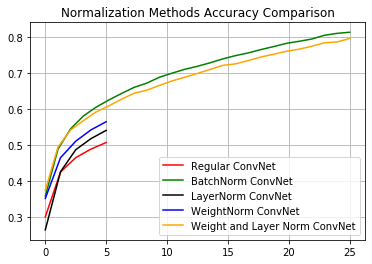

In [19]:
reg_accuracy = reg_history.history['accuracy']
bn_accuracy = bn_history.history['accuracy']
ln_accuracy = ln_history.history['accuracy']
wn_accuracy = wn_history.history['accuracy']
wln_accuracy = wln_history.history['accuracy']

plt.plot(np.linspace(0, epochs,  epochs), reg_accuracy,
             color='red', label='Regular ConvNet')

plt.plot(np.linspace(0, epochs_long, epochs_long), bn_accuracy,
         color='green', label='BatchNorm ConvNet')

plt.plot(np.linspace(0, epochs, epochs), ln_accuracy,
         color='black', label='LayerNorm ConvNet')

plt.plot(np.linspace(0, epochs, epochs), wn_accuracy,
         color='blue', label='WeightNorm ConvNet')

plt.plot(np.linspace(0, epochs_long, epochs_long), wln_accuracy,
         color='orange', label='Weight and Layer Norm ConvNet')

plt.title('Normalization Methods Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

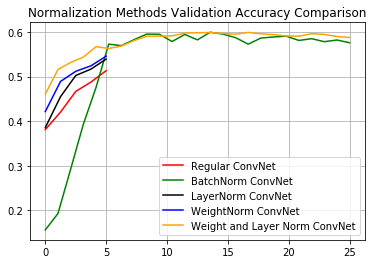

In [20]:
reg_accuracy = reg_history.history['val_accuracy']
bn_accuracy = bn_history.history['val_accuracy']
ln_accuracy = ln_history.history['val_accuracy']
wn_accuracy = wn_history.history['val_accuracy']
wln_accuracy = wln_history.history['val_accuracy']

plt.plot(np.linspace(0, epochs,  epochs), reg_accuracy,
             color='red', label='Regular ConvNet')

plt.plot(np.linspace(0, epochs_long, epochs_long), bn_accuracy,
         color='green', label='BatchNorm ConvNet')

plt.plot(np.linspace(0, epochs, epochs), ln_accuracy,
         color='black', label='LayerNorm ConvNet')

plt.plot(np.linspace(0, epochs, epochs), wn_accuracy,
         color='blue', label='WeightNorm ConvNet')

plt.plot(np.linspace(0, epochs_long, epochs_long), wln_accuracy,
         color='orange', label='Weight and Layer Norm ConvNet')

plt.title('Normalization Methods Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()